<a href="https://colab.research.google.com/github/Hit07/ML-DL-Torch/blob/main/Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Classification with Pytorch

* Architecture of a neural network classification model
* Input shapes and output shapes of a classification model (features and labels)
* Creating custom data to view, fit on and predict on
* Steps in modelling
- * Creating a model, setting a loss function and optimiser, creating a training loop, evaluating a model
* Saving and loading models
* Harnessing the power of non-linearity
* Different classification evaluation methods

## Import Statements

In [39]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from helper_functions import plot_predictions, plot_decision_boundary

## Toy Dataset (```sklearn.datasets```)

In [3]:
n_samples = 1000
X,y = make_circles(n_samples,noise=0.03,random_state=42)
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
len(X),len(y)

# Create Dataframe of circle data

df_circles = pd.DataFrame({'X1': X[:,0],
                           "X2":X[:,1],
                           'Label':y } )
df_circles[:5]

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


  **Note:** The data we're working with is often referred to as a toy dataset, a dataset that is small
enough to experiment but still sizeable enough to practice
the fundamentals

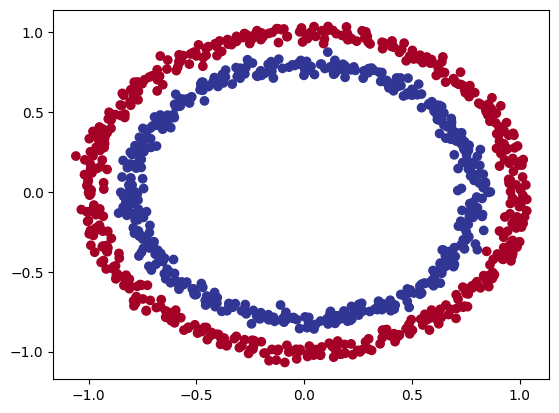

In [5]:
plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [6]:
df_circles.shape

(1000, 3)

In [7]:
df_circles.Label.value_counts()

Label
1    500
0    500
Name: count, dtype: int64

In [8]:
# turning data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [9]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
type(X),X.dtype,y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# Split data into training and test

X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=42)

print(X_train.shape,X_test.shape,y_test.shape,y_train.shape)


torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([200]) torch.Size([800])


## Build  a Model


To do so, we want to:
1. Setup devive agnostic code
2. Construct a model (by subclassing ```nn.Module``` )
3. Define a loss function and optimizer
4. Create a training and test loop


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_test.to(device),y_train.to(device)

In [14]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]], device='cuda:0')

In [15]:
X_train.device

device(type='cuda', index=0)


1. Subclasses ```nn.Module``` (almost all models in PyTorch subclass nn.Module)

2. Create 2 ```nn. Linear()``` layers that are capable of handling the shapes of our data

3. Defines a ```forward()``` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target device

In [16]:

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

# Replicate the model using ```nn.Sequential```

In [17]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4730, -0.1084],
                      [ 0.5623,  0.6528],
                      [-0.3434, -0.2323],
                      [-0.0040, -0.0601],
                      [-0.3173,  0.5484]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2373, -0.6614, -0.3824, -0.5822,  0.4834], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.2265, -0.3285, -0.1355, -0.2396, -0.2158]], device='cuda:0')),
             ('1.bias', tensor([-0.3242], device='cuda:0'))])

In [19]:
# Making predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
len(untrained_preds),untrained_preds[:10]

(200,
 tensor([[-0.3008],
         [-0.3721],
         [-0.0027],
         [-0.3857],
         [ 0.1733],
         [ 0.1284],
         [-0.2121],
         [-0.0945],
         [-0.0106],
         [-0.3750]], device='cuda:0'))

In [20]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 800, Shape: torch.Size([800])

First 10 predictions:
tensor([[-0.3008],
        [-0.3721],
        [-0.0027],
        [-0.3857],
        [ 0.1733],
        [ 0.1284],
        [-0.2121],
        [-0.0945],
        [-0.0106],
        [-0.3750]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.], device='cuda:0')


## Setting up loss function and Optimiser


* For example for regression you might want MAE Or MSE (mean absolute error or mean squared error)
* For classification you might want binary cross entropy or categorical cross entropy(cross entropy)

In [21]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [22]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc


## Train Model

### Going from raw logits > prediction probabilities > prediction labels

1. Our model outputs are going to be raw **logits**.
We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).


2. Then we can convert our model's prediction probabilities to prediction labels by either rounding them(binary classification) or taking the argmax () (softmax) .

In [23]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3008],
        [-0.3721],
        [-0.0027],
        [-0.3857],
        [ 0.1733]], device='cuda:0')

In [24]:
# Using sigmoid activation function on logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4254],
        [0.4080],
        [0.4993],
        [0.4048],
        [0.5432]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [25]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [26]:
# Combine the three steps
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))
accuracy_fn(y_preds,y_pred_labels)

100.0

In [27]:
X_train.shape, X_test.shape, y_train.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([200]),
 torch.Size([800]))

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=500

for epoch in range(epochs):

  model_0.train()
  y_logits = model_0(X_train).squeeze() # Imp:
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train.squeeze()) #Imp:
  acc = accuracy_fn(y_train.squeeze(),y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze() # Imp:
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test.squeeze())# Imp:
    test_acc = accuracy_fn(y_test.squeeze(),test_preds)

  if epoch % 10 == 0:
     print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69347, Accuracy: 51.25% | Test loss: 0.69255, Test acc: 51.00%
Epoch: 10 | Loss: 0.69339, Accuracy: 51.25% | Test loss: 0.69264, Test acc: 50.00%
Epoch: 20 | Loss: 0.69333, Accuracy: 51.50% | Test loss: 0.69273, Test acc: 48.50%
Epoch: 30 | Loss: 0.69328, Accuracy: 51.75% | Test loss: 0.69283, Test acc: 50.00%
Epoch: 40 | Loss: 0.69324, Accuracy: 51.75% | Test loss: 0.69292, Test acc: 50.00%
Epoch: 50 | Loss: 0.69320, Accuracy: 50.75% | Test loss: 0.69301, Test acc: 53.00%
Epoch: 60 | Loss: 0.69317, Accuracy: 50.25% | Test loss: 0.69310, Test acc: 55.00%
Epoch: 70 | Loss: 0.69315, Accuracy: 52.00% | Test loss: 0.69318, Test acc: 53.50%
Epoch: 80 | Loss: 0.69313, Accuracy: 52.12% | Test loss: 0.69326, Test acc: 51.50%
Epoch: 90 | Loss: 0.69311, Accuracy: 52.88% | Test loss: 0.69334, Test acc: 50.00%
Epoch: 100 | Loss: 0.69309, Accuracy: 52.38% | Test loss: 0.69341, Test acc: 48.50%
Epoch: 110 | Loss: 0.69308, Accuracy: 51.88% | Test loss: 0.69348, Test acc: 49.50%
Epo

In [92]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path( "helper_functions.py").is_file() :
  print("helper_functions.py already exists, skipping download" )
else:
  print ("Download helper_functions.py")
  request = requests.get ("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

with open("helper_functions.py", "wb") as file:
  file.write (request.content)





Download helper_functions.py


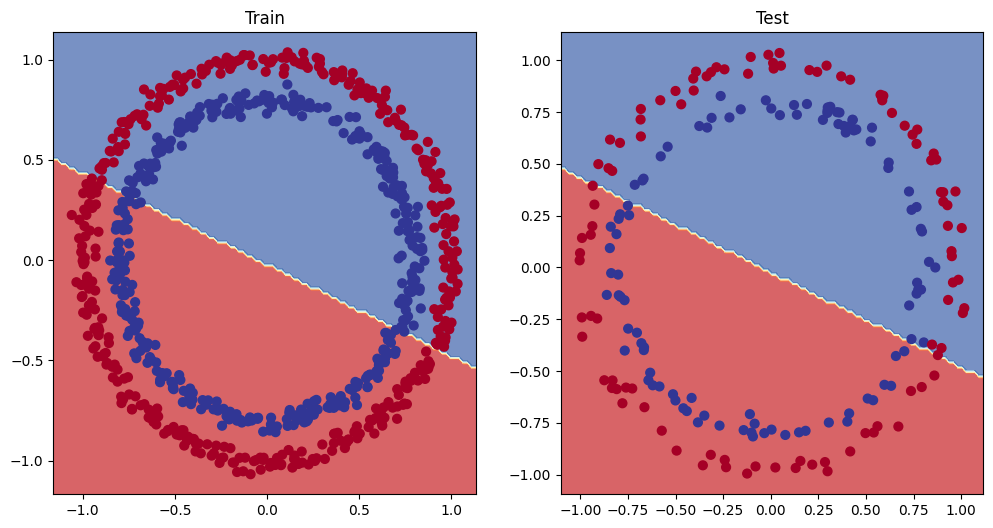

In [38]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.show()

# Improving the Model

Our model is showing less than 50% which means its just guessing

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the model, rather than the data.
And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as **hyperparameters**.

In [ ]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5435,  0.5885],
                      [-0.1882,  0.6366],
                      [-0.1619,  0.1386],
                      [-0.3315,  0.4226],
                      [ 0.6150, -0.5235]])),
             ('layer_1.bias',
              tensor([0.6104, 0.1652, 0.5310, 0.0767, 0.3528])),
             ('layer_2.weight',
              tensor([[-0.0621,  0.3464,  0.1206, -0.1944,  0.1260]])),
             ('layer_2.bias', tensor([-0.1120]))])

In [ ]:
class CircleModelV1(nn.Module) :
  def __init__ (self) :
    super().__init__()
    self. layer_1 = nn. Linear (in_features=2, out_features=10)
    self.layer_2 = nn.Linear (in_features=10, out_features=10)
    self. layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward (self, x) :
    # z = self. layer_1 (x)
    # z = self. layer_2 (z)
    # z = self. layer_3 (2)
    return self. layer_3(self. layer_2(self.layer_1(x) ))


model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# train loop

torch.manual_seed(42)
epochs =1000

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train.squeeze())
    acc = accuracy_fn(y_true=y_train.squeeze(), y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test.squeeze())
        test_acc = accuracy_fn(y_true=y_test.squeeze(), y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")






Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 200 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 300 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 400 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 500 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 600 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 700 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 800 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 900 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%


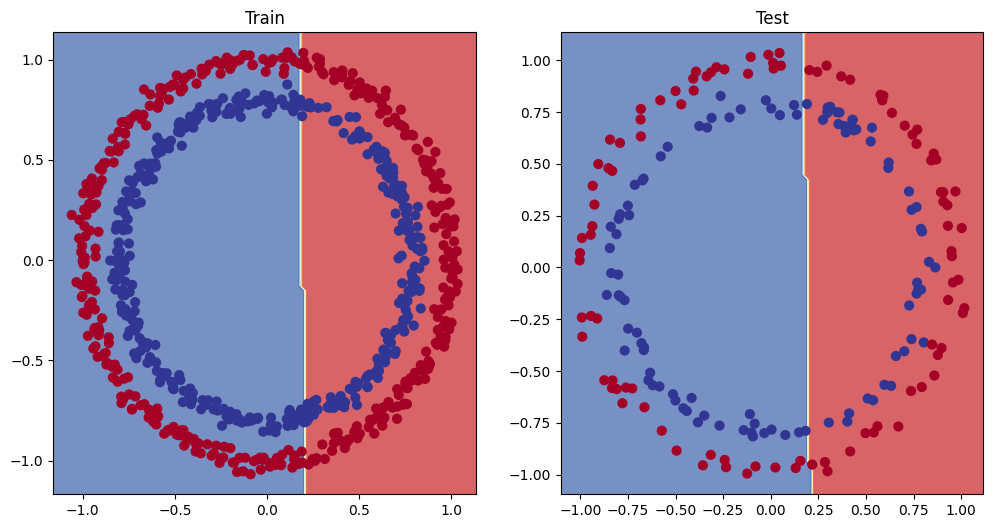

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)
plt.show()

# Preparing the data to see if our model works!

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange (start, end, step).unsqueeze (dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)
print(len (X_regression))
X_regression[:5], y_regression[ :5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test splits train
train_split = int(0.8 * len (X_regression) )
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[ :train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split: ]

len(X_train_regression),len (X_test_regression), len(y_train_regression), len(y_test_regression)


(80, 20, 80, 20)

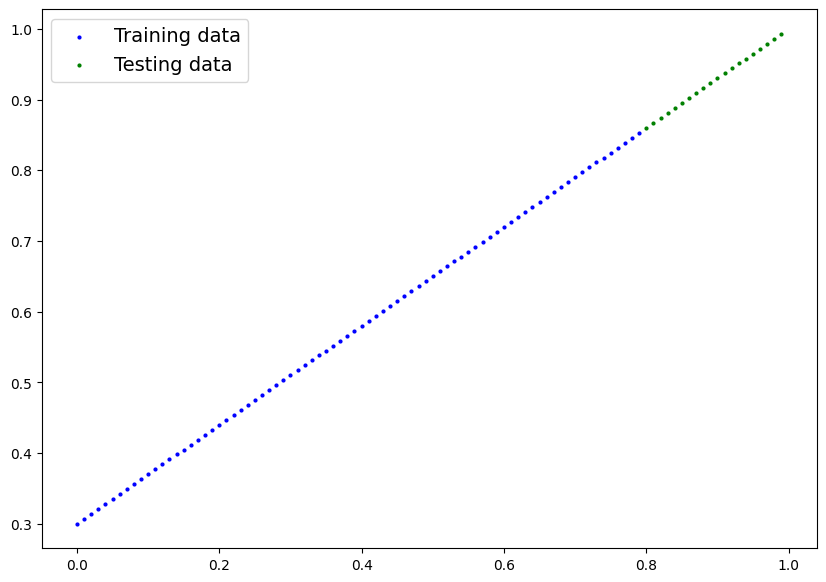

In [ ]:
plot_predictions(train_data=X_train_regression,
                  train_labels=y_train_regression,
                  test_data=X_test_regression,
                  test_labels=y_test_regression);

In [ ]:
# Same architecture as model_1 (but using nn.Sequent
model_2 = nn.Sequential(nn.Linear (in_features=1, out_features=10),
                        nn.Linear (in_features=10, out_features=10),
                        nn.Linear (in_features=10, out_features=1)).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.01)


In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 500

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)
# Training

for epoch in range (epochs) :
  y_pred = model_2 (X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss. backward ()
  optimizer.step()

  # Testing
  model_2. eval()
  with torch. inference_mode () :
    test_pred = model_2 (X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)
  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: 5f} | Test loss: {test_loss: 5f}" )

Epoch: 0 | Loss:  0.006964 | Test loss:  0.001086
Epoch: 100 | Loss:  0.006350 | Test loss:  0.001208
Epoch: 200 | Loss:  0.006037 | Test loss:  0.000979
Epoch: 300 | Loss:  0.006330 | Test loss:  0.001663
Epoch: 400 | Loss:  0.006311 | Test loss:  0.001365


In [ ]:
model_2.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6820],
                      [ 0.8820],
                      [-0.4328],
                      [ 1.0708],
                      [-0.3552],
                      [ 0.2890],
                      [-0.6714],
                      [ 0.6920],
                      [ 1.1008],
                      [-0.8468]])),
             ('0.bias',
              tensor([ 0.5016,  0.0066,  0.5985, -0.0504,  0.4256, -0.1627,  0.6985, -0.0447,
                      -0.5218,  0.2851])),
             ('1.weight',
              tensor([[ 0.0071,  0.0987, -0.1272,  0.3423, -0.2554, -0.1277, -0.1302, -0.1091,
                        0.1348, -0.4166],
                      [ 0.2605, -0.2391,  0.1805,  0.0823, -0.1514,  0.2105, -0.0376,  0.2666,
                        0.1161, -0.1622],
                      [-0.0318, -0.1329,  0.0619,  0.2345,  0.1380, -0.1288,  0.1129,  0.0219,
                        0.1814, -0.1953],
                      [-0.0937,  0.0328, -0

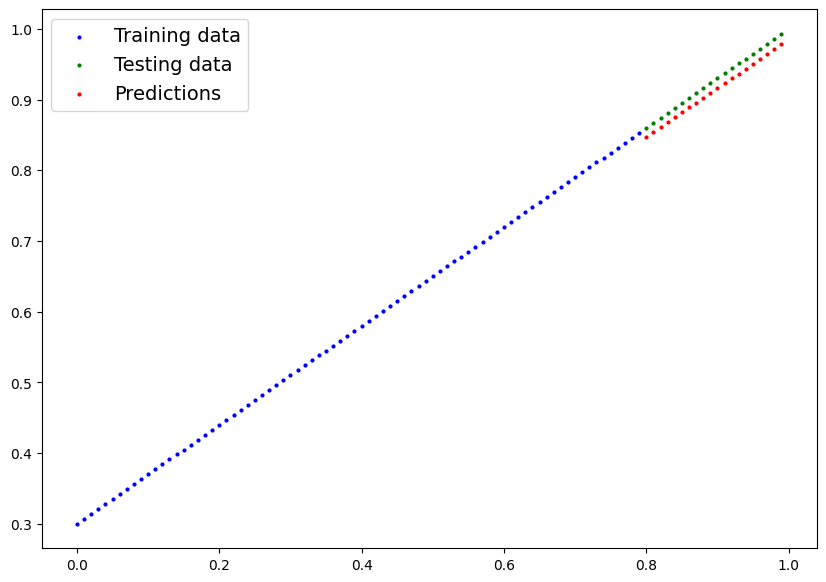

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)

with torch. inference_mode() :
  y_preds = model_2(X_test_regression)
# Plot data and predictions
plot_predictions (train_data=X_train_regression,
                  train_labels=y_train_regression,
                  test_data=X_test_regression,
                  test_labels=y_test_regression,
                  predictions=y_preds)

# Non-Linearity

nn.ReLU() --> using combinations of Linear and Non-Linear functions

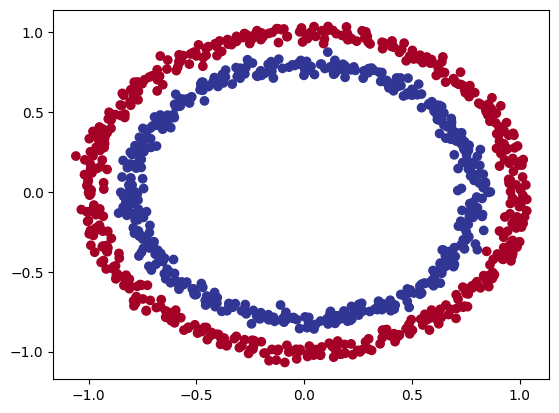

In [90]:
n_samples = 1000
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)
plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [91]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [92]:
# Splitting data into train and testing

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# len(X_train),len(X_test),len(y_train),len(y_test)

X_train,X_test = X_train.to(device),X_test.to(device)
y_train,y_test = y_train.to(device),y_test.to(device)


In [93]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=10)
    self.layer3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x:torch.Tensor)->torch.Tensor:
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

# random_seed
torch.manual_seed(42)

# Instatiate model
model_3 = CircleModelV2().to(device)
model_3

list(model_3.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188],
         [ 0.6146,  0.1323],
         [ 0.5224,  0.0958],
         [ 0.3410, -0.0998],
         [ 0.5451,  0.1045],
         [-0.3301,  0.1802]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
          0.0667, -0.6984], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
           0.0346, -0.0997],
         [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
           0.1606, -0.1927],
         [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310,  0.1000, -0.0055,
           0.2475, -0.2247],
         [ 0.0199, -0.2158,  0.0975, -0.1089,  0.0969, -0.0659,  0.2623, -0.1874,
          -0.1886, -0.1886],
         [ 

In [94]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.1)

In [95]:
torch.cuda.manual_seed(42)
epochs = 1500
# train loop
for epoch in range(epochs):
  model_3.train()
  y_logits = model_3(X_train).squeeze()
  y_predictions = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits,y_train.squeeze())
  acc = accuracy_fn(y_true=y_train.squeeze(),y_pred=y_predictions)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_y_logits = model_3(X_test).squeeze()
    test_y_predictions = torch.round(torch.sigmoid(test_y_logits))
    loss = loss_fn(test_y_logits,y_test.squeeze())
    test_acc = accuracy_fn(y_true=y_test.squeeze(),y_pred=test_y_predictions)

  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69319, Accuracy: 50.00% | Test loss: 0.69456, Test acc: 50.00%
Epoch: 100 | Loss: 0.69102, Accuracy: 52.88% | Test loss: 0.69456, Test acc: 52.50%
Epoch: 200 | Loss: 0.68940, Accuracy: 53.37% | Test loss: 0.69456, Test acc: 55.00%
Epoch: 300 | Loss: 0.68723, Accuracy: 53.00% | Test loss: 0.69456, Test acc: 56.00%
Epoch: 400 | Loss: 0.68411, Accuracy: 52.75% | Test loss: 0.69456, Test acc: 56.50%
Epoch: 500 | Loss: 0.67941, Accuracy: 52.75% | Test loss: 0.69456, Test acc: 56.50%
Epoch: 600 | Loss: 0.67285, Accuracy: 54.50% | Test loss: 0.69456, Test acc: 56.00%
Epoch: 700 | Loss: 0.66322, Accuracy: 58.38% | Test loss: 0.69456, Test acc: 59.00%
Epoch: 800 | Loss: 0.64757, Accuracy: 64.00% | Test loss: 0.69456, Test acc: 67.50%
Epoch: 900 | Loss: 0.62145, Accuracy: 74.00% | Test loss: 0.69456, Test acc: 79.00%
Epoch: 1000 | Loss: 0.57378, Accuracy: 87.75% | Test loss: 0.69456, Test acc: 86.50%
Epoch: 1100 | Loss: 0.49935, Accuracy: 93.50% | Test loss: 0.69456, Test acc:

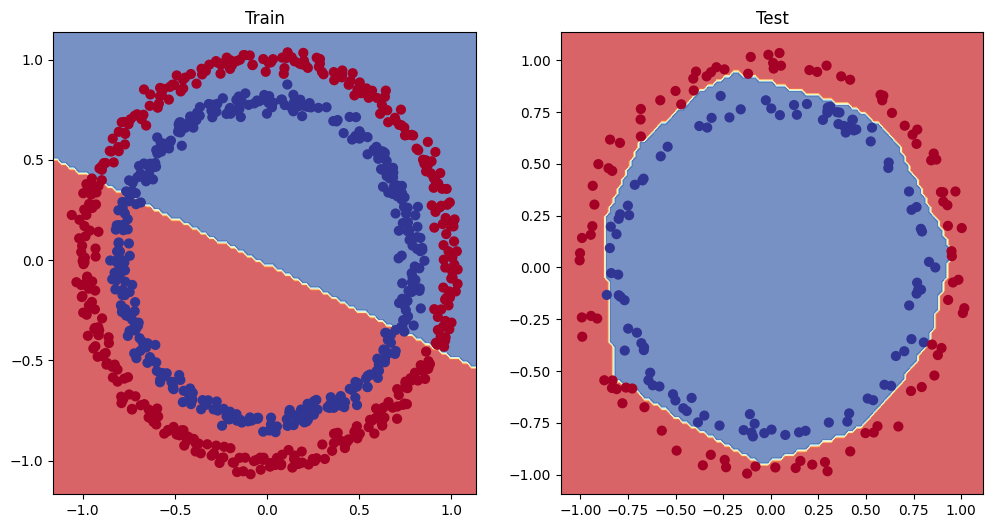

In [96]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)
plt.show()

# Multi-Class Classification

- Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
- Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

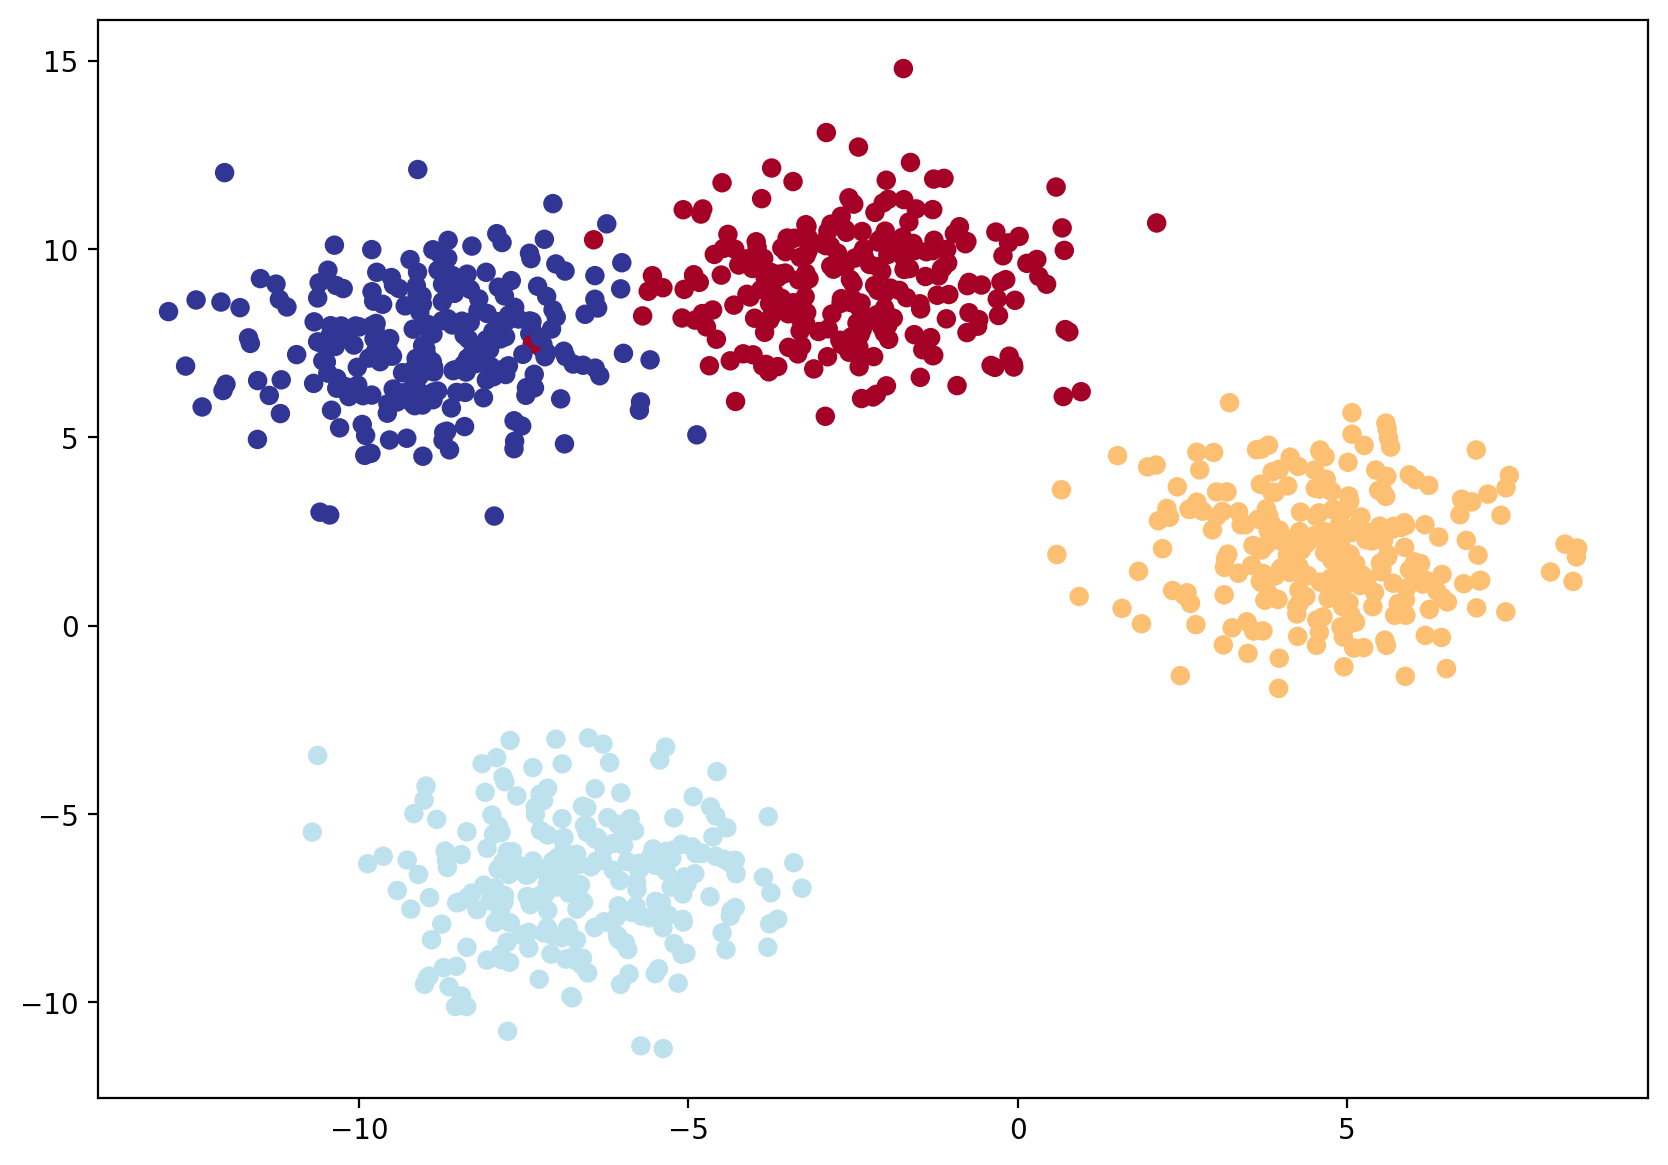

In [93]:
# Dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from helper_functions import plot_decision_boundary

# hyperparamters
NUM_CLASS = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create Features and Labels for Multiclass Model
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers = NUM_CLASS,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED
                           )

# Turn into Tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # We need to use int64

# Split into train and test
X_blob_train,X_blob_test,y_blob_train,y_blob_test= train_test_split(X_blob,
                                                                    y_blob,
                                                                    test_size=0.2,
                                                                    random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10,7),dpi=200)
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

# Building Multiclass Model

In [94]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [95]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    """
       Initializes multi-class classification model.

        Args:
        input_features (int): Number of input features to the model
        output_features (int): Number of outputs features (number of output classes)
        hidden_units (int): Number of hidden units between layers, default 8

        Returns:
        Example: """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features,out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units,out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)


model_4  = BlobModel(input_features=2,
                     output_features=4).to(device)



In [96]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [97]:
X_blob_train,X_blob_test = X_blob_train.to(device),X_blob_test.to(device)
y__blob_train,y_blob_test = y_blob_train.to(device),y_blob_test.to(device)

In [98]:
# Setup loss function and Optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params=model_4.parameters(),lr=0.1)

In [99]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc


####  We need to pass our logits(raw output) where each sample is output as 4 features which needs to be passed into activiation function

- In order to evaluate and train and test our model, we need to convert our model's outputs (logtis) to predicition probabilities and then to prediction labels.
- Logits (raw output of the model) -> Pred probs (use `torch.softmax`) →> Pred labels
(take the argmax of the prediction probabilities)

In [100]:
# Logits
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_train)
y_logits


tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        ...,
        [-0.2564, -1.2652, -1.0365, -0.3130],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.0502, -0.8423, -0.4798, -0.0988]])

In [101]:
# Target output
y_blob_test[:5]
torch.unique(y_blob_test)

tensor([0, 1, 2, 3])

In [102]:
# Activation function --> Prediction probabilities
y_preds = torch.softmax(y_logits,dim=1)
y_preds

tensor([[0.3080, 0.3328, 0.1441, 0.2150],
        [0.3577, 0.1324, 0.1696, 0.3402],
        [0.3011, 0.1843, 0.2823, 0.2323],
        ...,
        [0.3613, 0.1317, 0.1656, 0.3414],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3272, 0.1482, 0.2129, 0.3117]])

In [103]:
torch.sum(y_preds[0]) # Sums upto to 1
torch.argmax(y_preds[0]) # To determine which class it belongs

tensor(1)

In [104]:
# Convert preditiction probabilities to prediction labels
y_preds = torch.argmax(y_preds,dim=1)


In [105]:
y_preds[:50]

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        3, 0, 3, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0])

In [106]:
# Train loop

torch.manual_seed(42)
epochs = 900

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_blob_train,y_pred)
  optimiser.zero_grad()
  loss.backward()
  optimiser.step()

  model_4.eval()
  with torch.inference_mode():
    test_y_logits = model_4(X_blob_test)
    test_y_pred = torch.softmax(test_y_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_y_logits,y_blob_test)
    test_acc = accuracy_fn(y_blob_test,test_y_pred)

  if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.15883, Accuracy: 40.38% | Test loss: 1.07554, Test acc: 48.00%
Epoch: 100 | Loss: 0.03312, Accuracy: 99.25% | Test loss: 0.02433, Test acc: 99.50%
Epoch: 200 | Loss: 0.02657, Accuracy: 99.25% | Test loss: 0.01651, Test acc: 99.50%
Epoch: 300 | Loss: 0.02503, Accuracy: 99.25% | Test loss: 0.01440, Test acc: 99.50%
Epoch: 400 | Loss: 0.02427, Accuracy: 99.25% | Test loss: 0.01335, Test acc: 99.50%
Epoch: 500 | Loss: 0.02377, Accuracy: 99.25% | Test loss: 0.01269, Test acc: 99.50%
Epoch: 600 | Loss: 0.02339, Accuracy: 99.25% | Test loss: 0.01218, Test acc: 99.50%
Epoch: 700 | Loss: 0.02307, Accuracy: 99.25% | Test loss: 0.01179, Test acc: 99.50%
Epoch: 800 | Loss: 0.02279, Accuracy: 99.25% | Test loss: 0.01147, Test acc: 99.50%


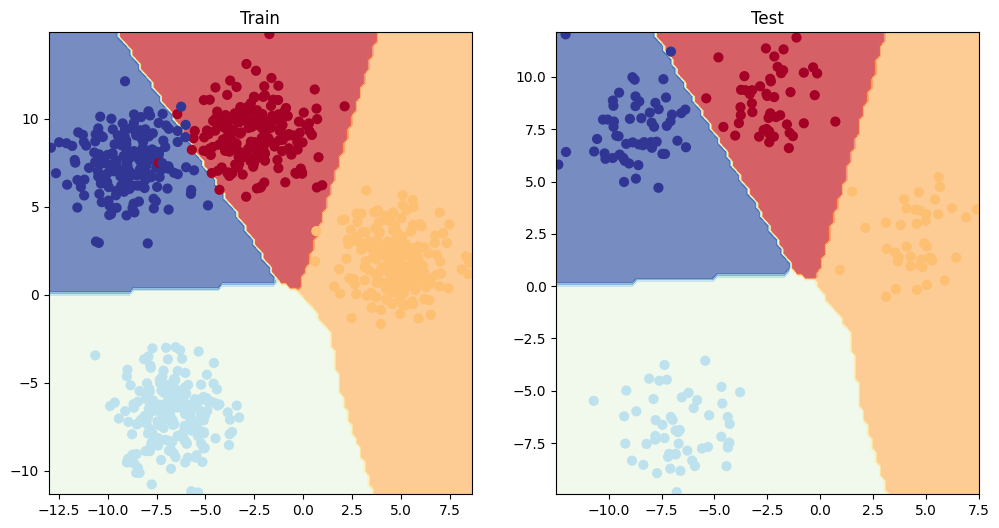

In [108]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)
plt.show()